In [1]:
import torch
from torchvision import datasets, transforms

cifar = datasets.CIFAR10("data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified


In [2]:
cifar.data.shape

(50000, 32, 32, 3)

In [3]:
CIFAR_MEAN = cifar.data.mean(axis=(0,1,2))
CIFAR_STD = cifar.data.std(axis=(0,1,2))
CIFAR_MEAN, CIFAR_STD

(array([125.30691805, 122.95039414, 113.86538318]),
 array([62.99321928, 62.08870764, 66.70489964]))

In [4]:
import torch
from torchvision import datasets, transforms

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10("data", train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
    ])), batch_size=16, shuffle=True, num_workers=8)

val_loader = torch.utils.data.DataLoader(datasets.CIFAR10("data", train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
    ])), batch_size=16, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


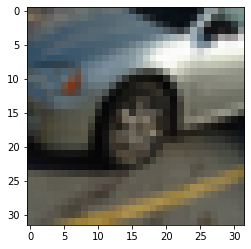

In [5]:
import matplotlib.pyplot as plt
plt.imshow(next(iter(train_loader))[0][0].permute(1, 2, 0) * CIFAR_STD + CIFAR_MEAN)
plt.show()

In [6]:
import pytorch_lightning as pl
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class CIFAR10Classifier(pl.LightningModule):
    def __init__(self, lr=1e-3, optimizer="adam"):
        super().__init__()
        self.save_hyperparameters()
        self.model = CIFAR10Model()
        self.criterion = nn.CrossEntropyLoss()
        self.metrics = {
            "accuracy": {
                "train": torchmetrics.Accuracy(),
                "val": torchmetrics.Accuracy()
            }
        }

    def step(self, batch, step_name="train"):
        X, y = batch
        outputs = self.model(X)
        loss = self.criterion(outputs, y)
        preds = self.forward(X)
        metric = self.metrics["accuracy"][step_name]
        metric.update(preds.cpu(), y.cpu())
        metric_val = metric.compute()
        self.log(f"{step_name}_loss", loss, on_epoch=True)
        self.log(f"{step_name}_accuracy", metric_val, on_epoch=True)
        return loss

    def forward(self, X, *args):
        return F.softmax(self.model(X), dim=1)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def predict_step(self, batch, batch_idx):
        X, y = batch
        return self.forward(X)

    def configure_optimizers(self):
        if self.hparams.optimizer == "sgd":
            return optim.SGD(self.model.parameters(), lr=self.hparams.lr)
        elif self.hparams.optimizer == "rmsprop":
            return optim.RMSprop(self.model.parameters(), lr=self.hparams.lr)
        elif self.hparams.optimizer == "adagrad":
            return optim.Adagrad(self.model.parameters(), lr=self.hparams.lr)

        return optim.Adam(self.model.parameters(), lr=self.hparams.lr)

In [8]:
import wandb
from pytorch_lightning.loggers import WandbLogger

NUM_EPOCHS = 2

wandb_logger = WandbLogger(project="optml-project", name=f"cifar10-adam")
# wandb_logger = True
model = CIFAR10Classifier()
trainer = pl.Trainer(default_root_dir="models/cifar10", max_epochs=NUM_EPOCHS, logger=wandb_logger, accelerator="gpu")
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mismayil. Use `wandb login --relogin` to force relogin


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | CIFAR10Model     | 62.0 K
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [6]:
torch.save(model.state_dict(), "ckpt/attack_model/emnist_cnn.pt")

In [29]:
from collections import OrderedDict
emnist_model_dict = OrderedDict({name.replace("model.", ""): parameter for name, parameter in model.state_dict().items()})
torch.save(emnist_model_dict, "ckpt/attack_model/emnist_cnn.pt")
# for name, parameter in model.state_dict().items():
#     print(name)

In [10]:
model = EMNISTClassifier(lr=1e-4)
model.load_state_dict(torch.load("ckpt/attack_model/emnist_cnn.pt"))
preds = trainer.predict(model, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/.conda/envs/optml/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 1875it [00:00, ?it/s]

In [14]:
preds = torch.cat(preds)

In [15]:
preds.shape

torch.Size([40000, 10])

In [16]:
preds = preds.argmax(dim=1)

In [17]:
val_targets = []

for _, y in val_loader:
    val_targets.append(y)

val_targets = torch.cat(val_targets)

In [18]:
val_targets.shape

torch.Size([40000])

In [20]:
(preds == val_targets).sum() / len(val_targets)

tensor(0.9899)

In [21]:
correct_indices = torch.where(preds == val_targets)[0]

In [22]:
correct_indices

tensor([    0,     1,     2,  ..., 39997, 39998, 39999])

In [33]:
import numpy as np

with open("data/emnist_correct/label_correct_index.npy", "wb") as f:
    np.save(f, correct_indices.numpy())